# *Phase contrast SXCT scan of Egyptian blue specimen - pore size analysis*

- By [Gianluca Iori](https://github.com/gianthk), 2024
- Code licence: MIT
- Narrative licence: CC-BY 
- How to cite: *Specify how you want people to cite this notebook. You can refer to a publication or a repository (e.g. link your GitHub repository to Zenodo - see [this video](https://www.youtube.com/watch?v=gp3D4mf6MHQ))*
- Created on:  18.05.2024
- Last update: 18.05.2024

---
# Aims
1. Read `.CSV` file of Max. Feret diameter of large spheric particles 
2. Load volume thickness map of small size pore network
3. Plot histogram of large particle size
4. Plot histogram of thin pore thickness

---
- Work on binary masks and the local thickness map used for this notebook is done in ORS Dragonfly.


---
# *Computational workflow*

## Configuration and imports

In [1]:
import os
import sys
sys.path.append('./../../recon_utils')
# sys.path.append('/home/gianthk/PycharmProjects/CT2FE')

Configure working folder (change this to your local path)

In [3]:
work_folder = "/home/gianthk/Data/BEATS/IH/egyptian_blue-20240229T135258/"
res_folder = os.path.join(work_folder, "results")

In [6]:
import numpy as np
import pandas as pd
import dxchange
import matplotlib
import matplotlib.pyplot as plt

from scipy import ndimage, stats # , misc
from skimage import morphology #, measure

from recon_utils import read_tiff_stack, plot_midplanes

Matplotlib plotting configuration

In [5]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

## Load data
### Load scalar dataset of small pore network volume thickness

In [8]:
input_file = os.path.join(work_folder,'small_voids_volume_thickness/slice_001.tif')

In [9]:
data_3D = read_tiff_stack(input_file)

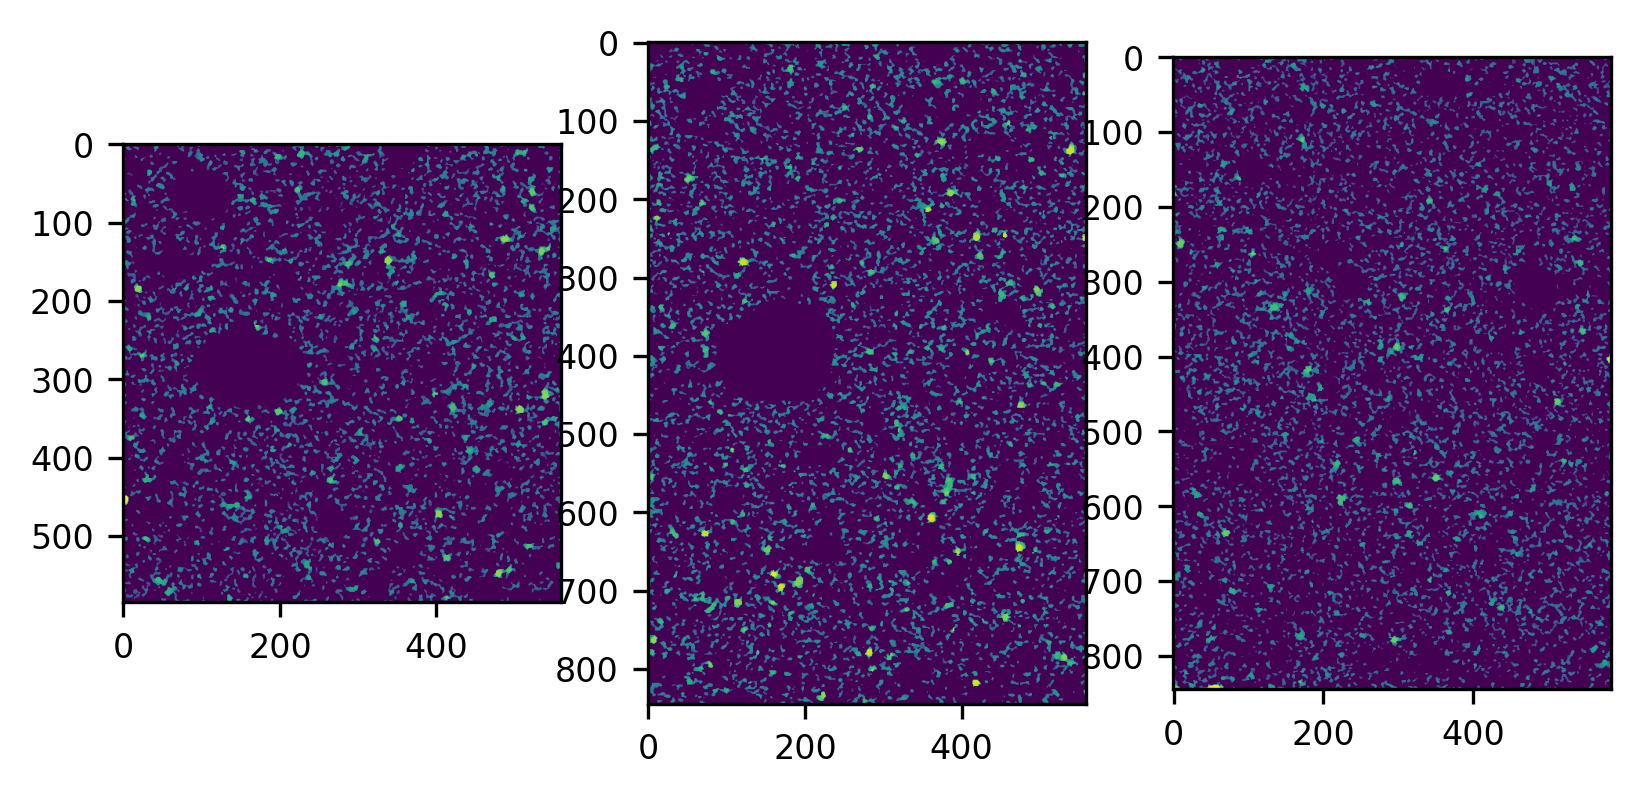

In [10]:
plot_midplanes(data_3D)

### Load pore measurements
- Pore measurements were performed in ORS Dragonfly
- The measurement was applied only to large spherical pores, which are excluded from the thickness map above

In [11]:
results_file = os.path.join(work_folder, 'blobs_large_multiROI_measurements.csv')

In [14]:
names = ['Time Step', 'Label Index', 'Name (NA)', 'Voxel count', 'Volume (mm³)', 'Max Feret Diameter (mm)', 'Sphericity']

In [16]:
measurements = pd.read_csv(results_file, sep=';', names=names, skiprows=[0])

In [17]:
measurements.head()

,Time Step,Label Index,Name (NA),Voxel count,Volume (mm³),Max Feret Diameter (mm),Sphericity
0,0,1,NaN,400.0,0.000095,0.069573,0.982406
1,0,2,NaN,400.0,0.000095,0.069589,0.982406
2,0,3,NaN,400.0,0.000095,0.069595,0.979847
3,0,4,NaN,400.0,0.000095,0.069318,0.981521
4,0,5,NaN,400.0,0.000095,0.071472,0.979847


## Plot histogram of large particle diameter

In [20]:
diameter = measurements['Max Feret Diameter (mm)']

In [21]:
kde = stats.gaussian_kde(diameter)
x = np.linspace(diameter.min(), diameter.max(), 100)
p = kde(x)

Text(0, 0.5, 'count')

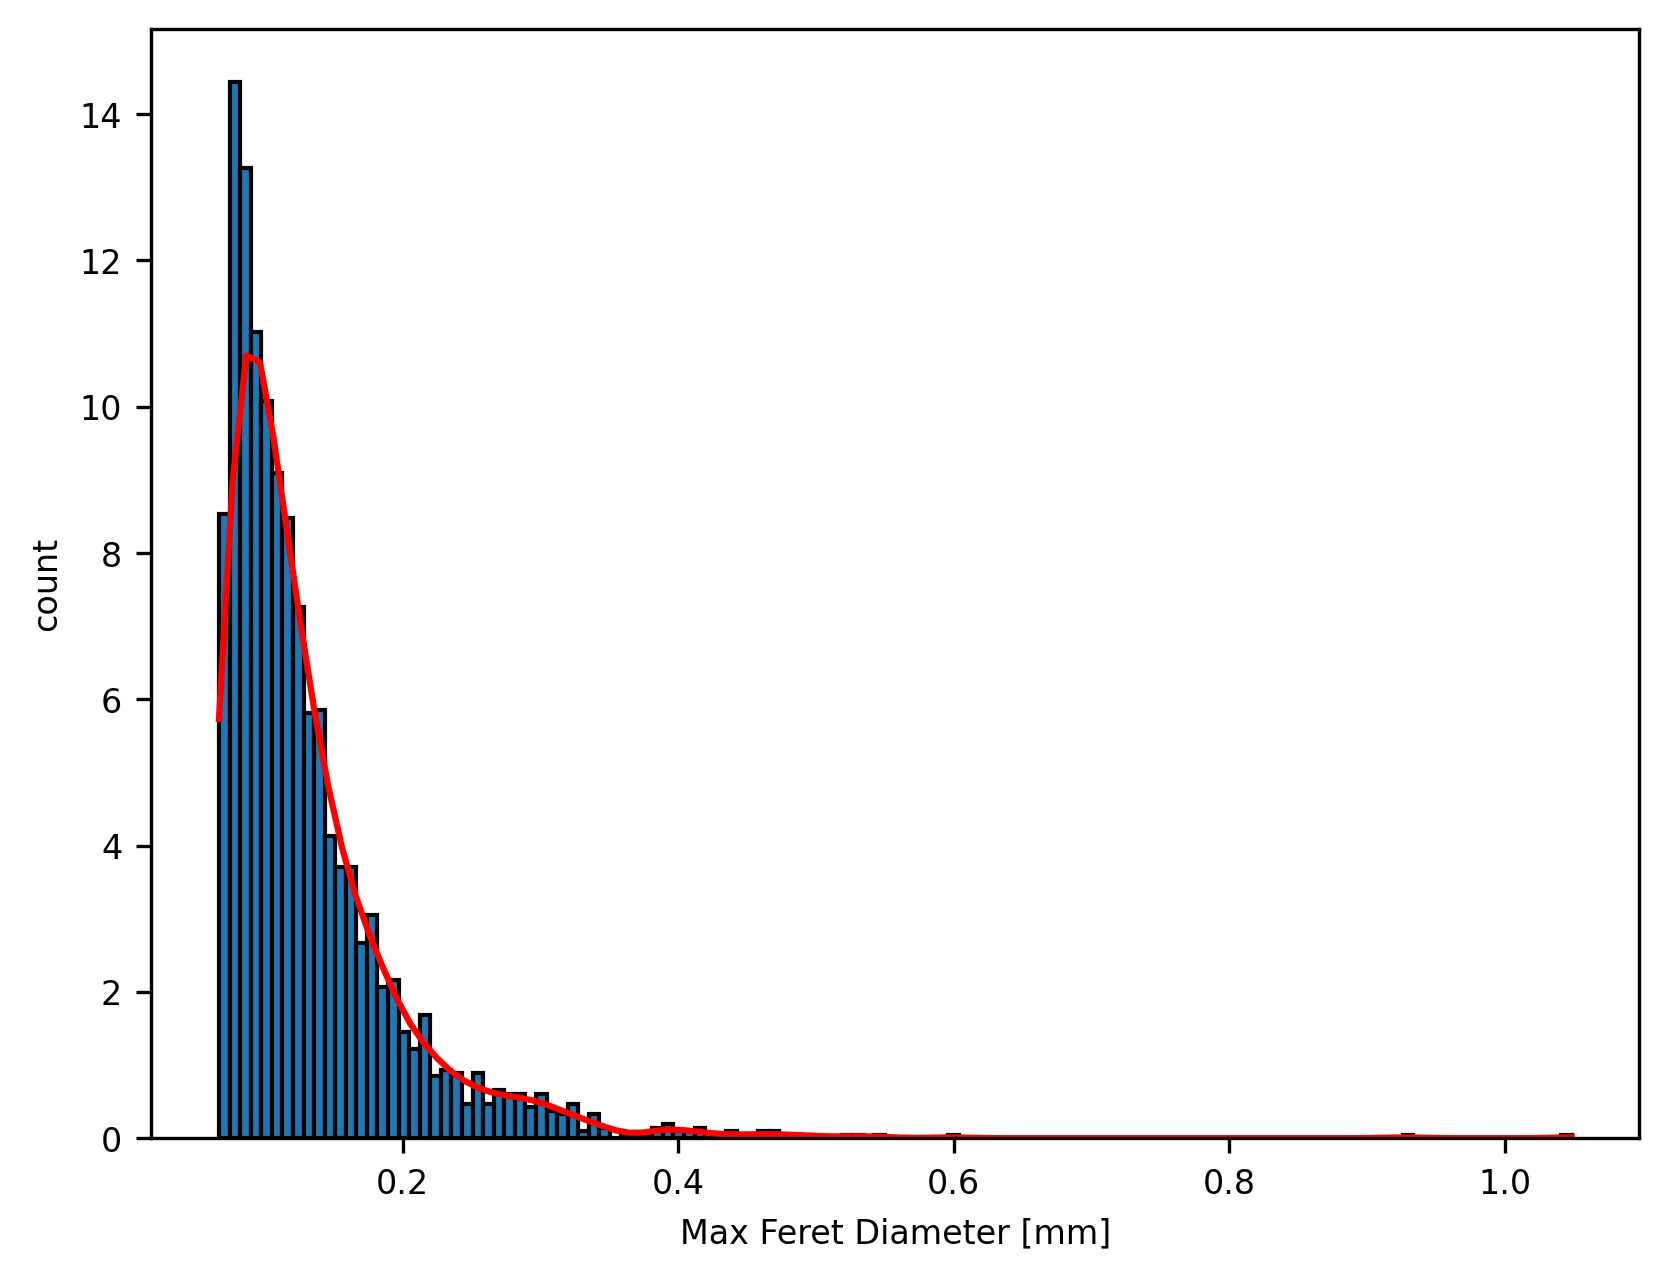

In [26]:
plt.figure()
plt.hist(measurements['Max Feret Diameter (mm)'], bins=128, edgecolor="k", density=True, label='Max Feret Diameter (mm)')
plt.plot(x, p, 'r', label='ksdensity')
plt.xlabel("Max Feret Diameter [mm]")
plt.ylabel("count")

## Median filter of volume thickness image

In [52]:
data_3D_filtered = ndimage.median_filter(data_3D.astype('float64'), 3)

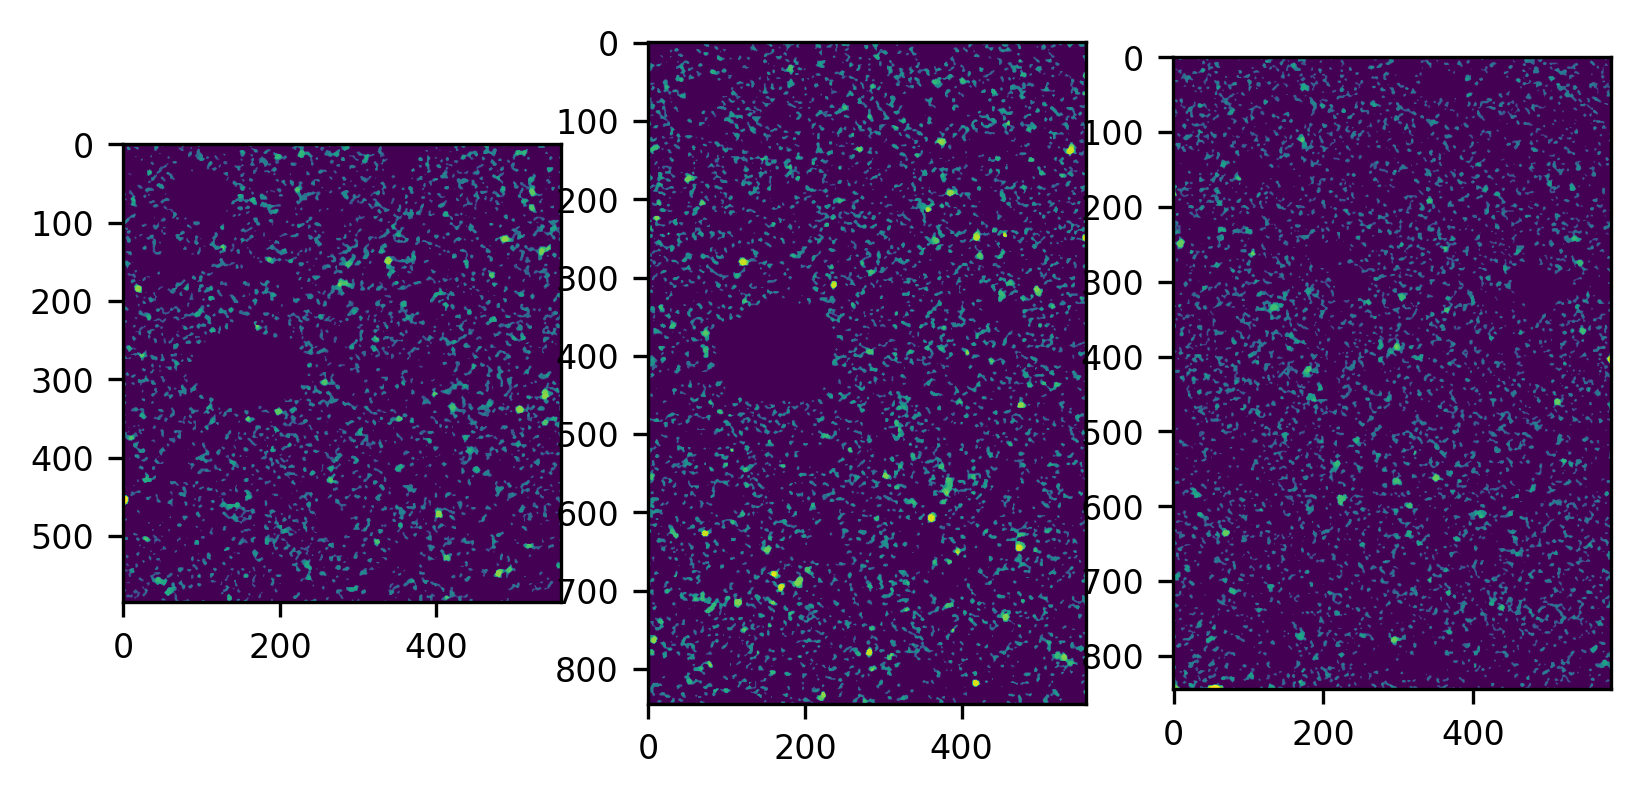

In [53]:
plot_midplanes(data_3D_filtered)

## Plot histogram of the thickness of fine pore network

In [56]:
data_3D_filtered.dtype

dtype('float64')

In [57]:
thickness = 1e3*np.random.choice(data_3D_filtered[data_3D_filtered > 0], 1000000)

In [60]:
kde = stats.gaussian_kde(thickness)
x = np.linspace(thickness.min(), thickness.max(), 128)
p = kde(x)

Text(0, 0.5, 'Counts')

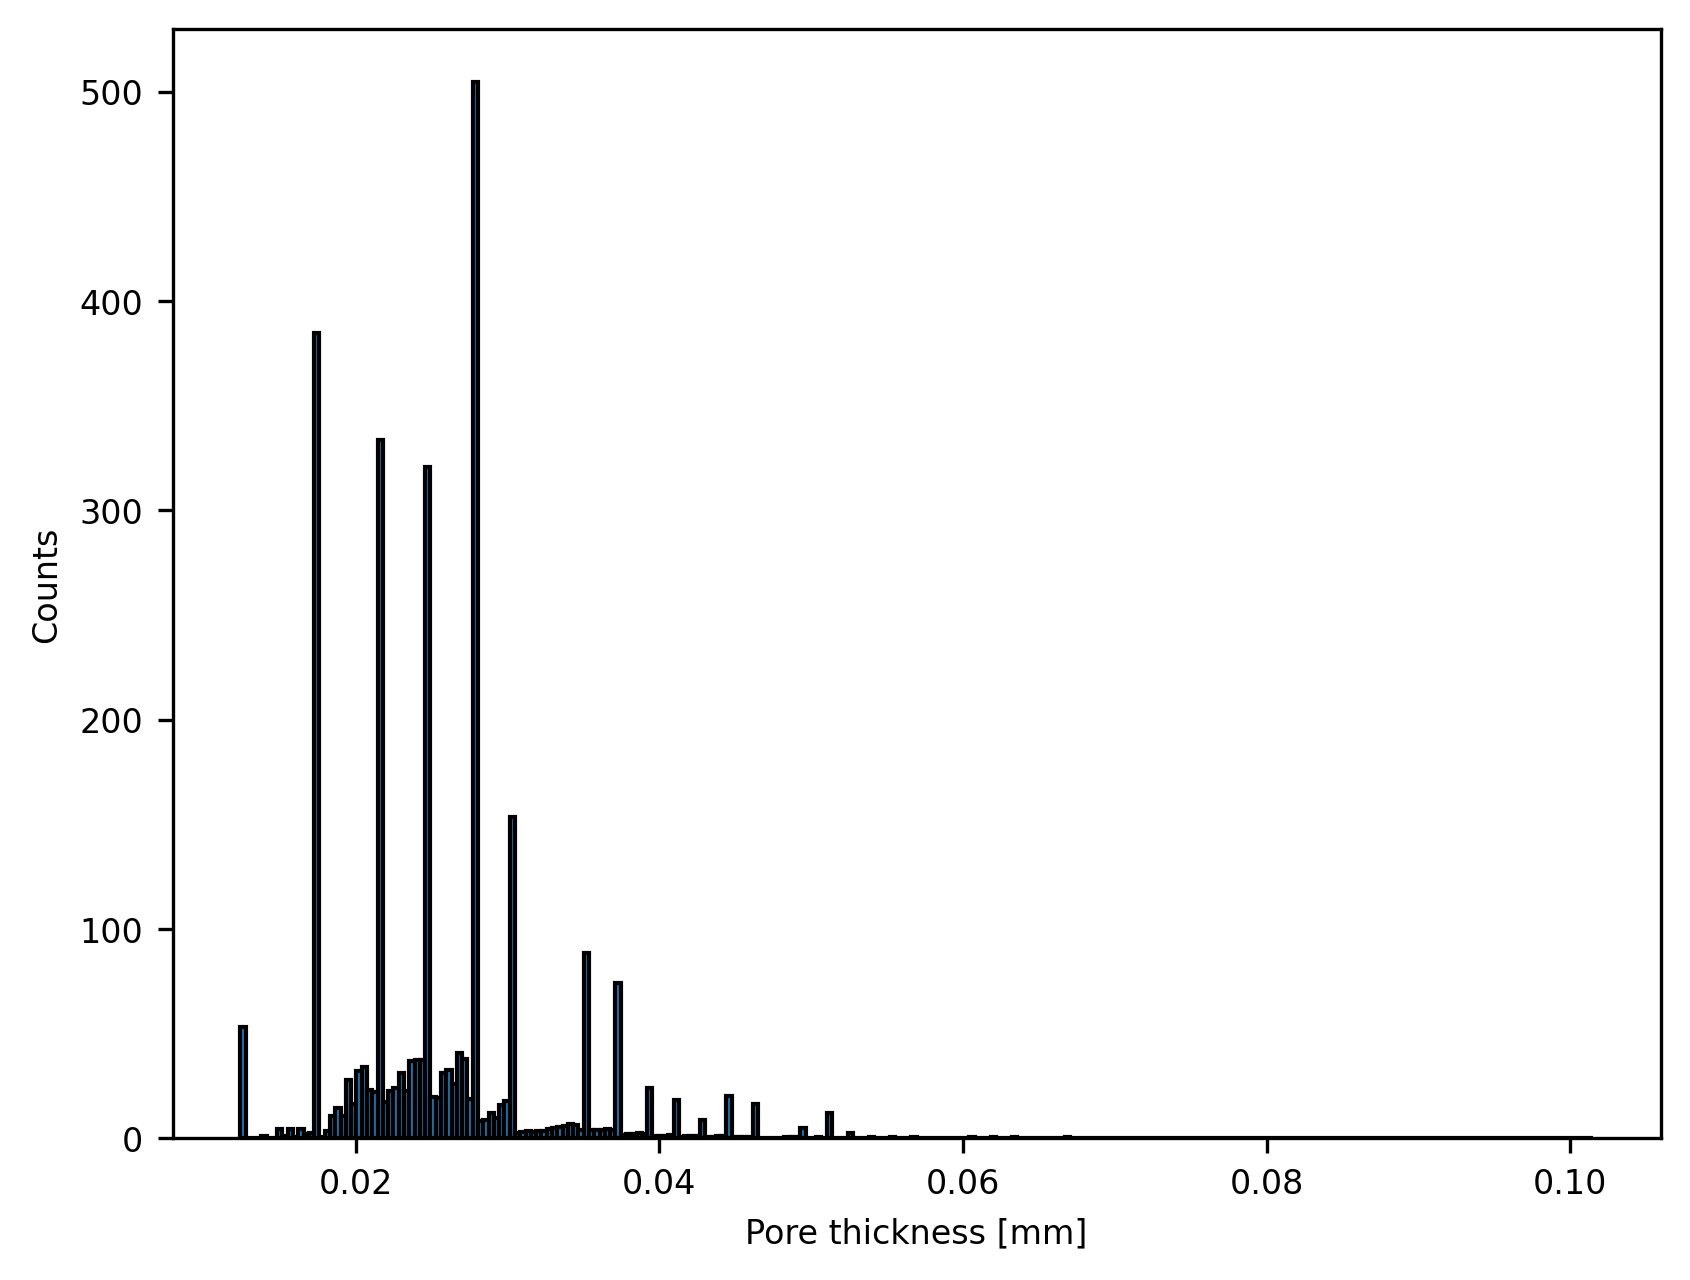

In [65]:
plt.figure()
plt.hist(thickness, bins=256, edgecolor="k", density=True, label='Pore thickness')
# plt.plot(x, p, 'r', label='ksdensity')
plt.xlabel("Pore thickness [mm]")
plt.ylabel("Counts")
# plt.legend()

In [69]:
print(np.median(thickness))
print(np.median(data_3D[data_3D>0])*1e3)

0.02479999966453761
0.02479999966453761


#### Plot histogram and Cumulative Density Function (CFD) of the particle distance from corrosion front

In [85]:
n_bins = 128
h, bins = np.histogram(distances_voids, bins=n_bins)

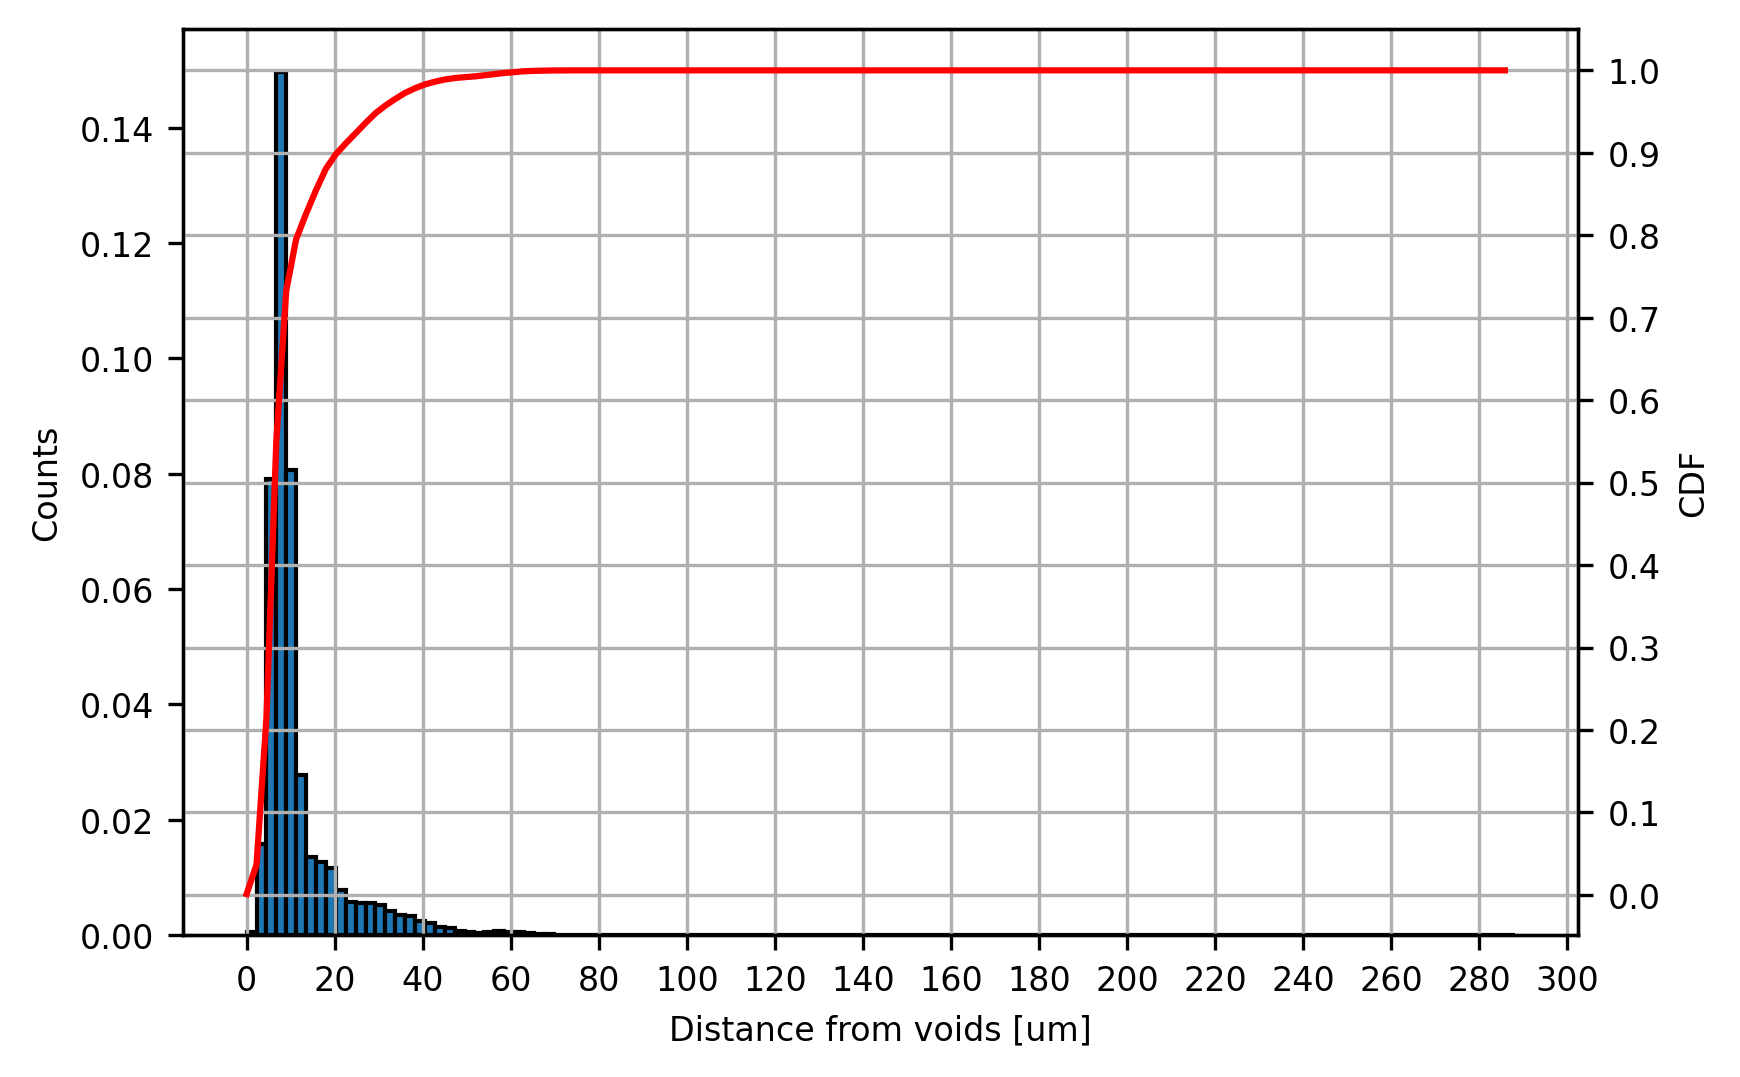

In [110]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax.hist(distances_voids, bins=n_bins, edgecolor="k", alpha=1, density=True, label='Distance from voids')
ax1.plot(bins[:-1], np.cumsum(h)/np.max(np.cumsum(h)), 'r')
ax.set_xlabel("Distance from voids [um]")
ax.set_xticks(np.arange(0, 320, 20))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylabel("Counts")
ax1.set_ylabel('CDF')
ax1.grid(which='both')
ax.grid(axis='x')

**90% of the particles is within 20 microns from a void area!!**

### Plot the distance of voids within the pit from the pit front
The distance transform image that we use has been downscaled with factor 2. Hence all distances must be multiplied by 2.

In [38]:
voids_dist_front = 2 * dist[BW_voids]

In [177]:
kde2 = stats.gaussian_kde(voids_dist_front)
x2 = np.linspace(voids_dist_front.min(), voids_dist_front.max(), 100)
p2 = kde2(x2)

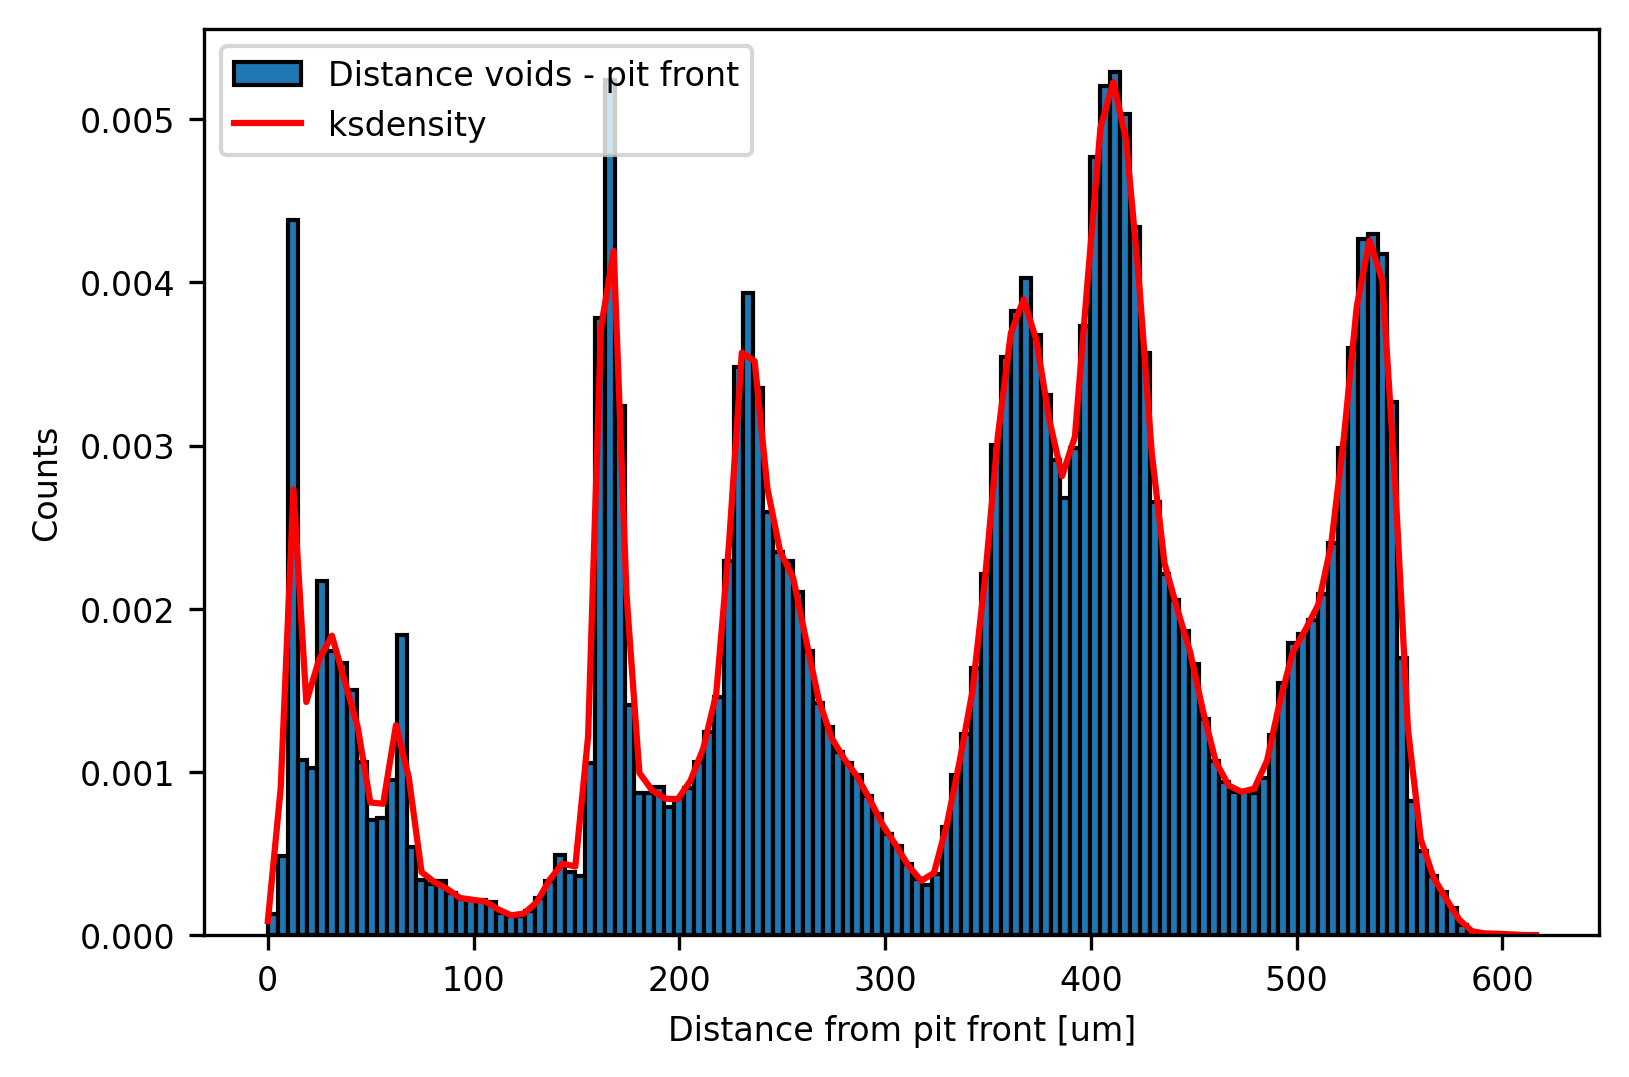

In [137]:
plt.figure()
plt.hist(voids_dist_front, bins=128, edgecolor="k", density=True, label='Distance voids - pit front')
plt.plot(x2, p2, 'r', label='ksdensity')
plt.xlabel("Distance from pit front [um]")
plt.ylabel("Counts")
plt.legend()

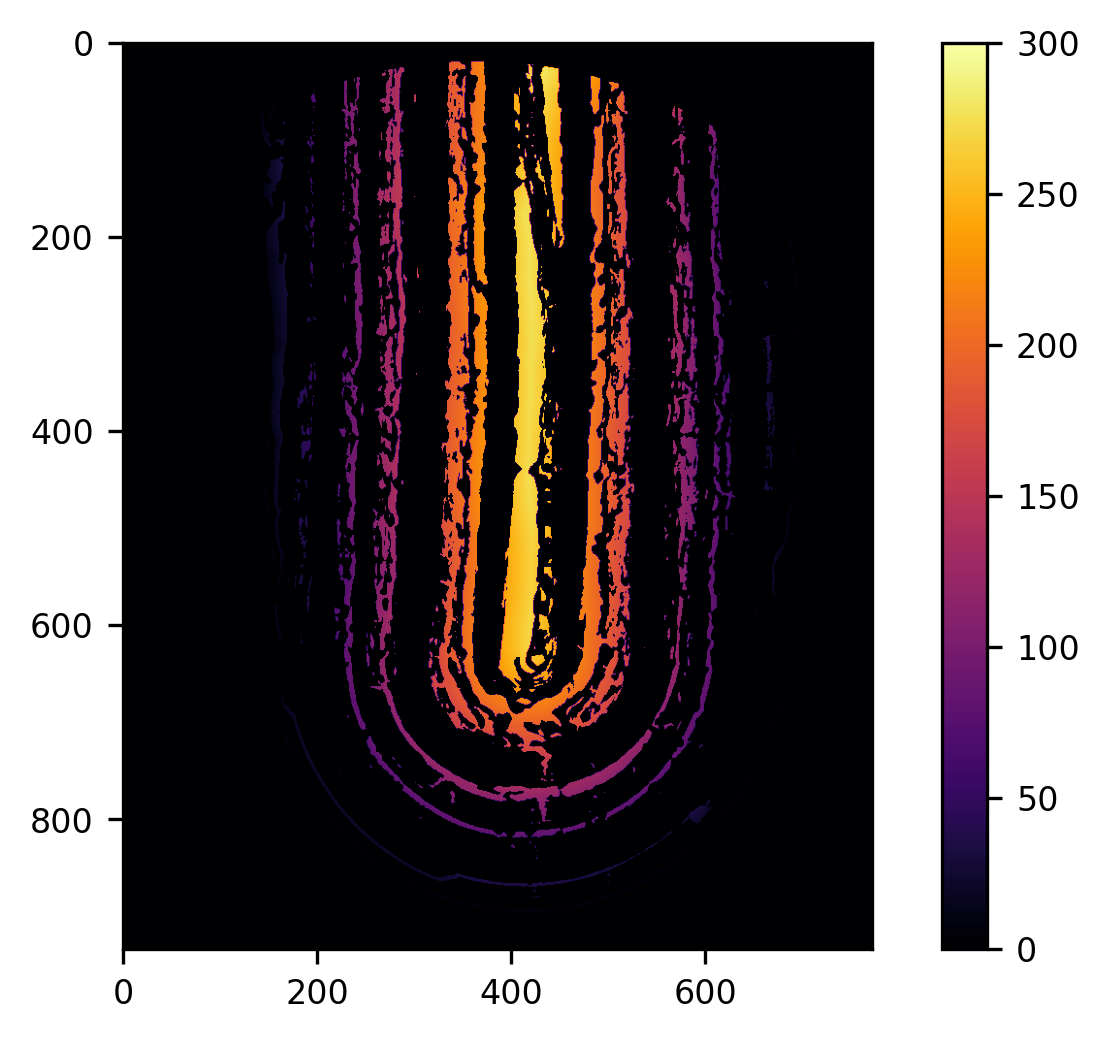

In [134]:
plt.imshow(2*dist[1500,:,:]*BW_voids[1500,:,:], cmap='inferno', vmax=600)
plt.colorbar()

## Color particles with given properties
Create scalar image of the labelled particles colored according to their volume, sphericity, or distance age. The `spam.label` toolkit is used.
- Particle sphericity:

In [ ]:
regions_sphericity = spam.label.convertLabelToFloat(regions, sphericity)

In [ ]:
# dxchange.write_tiff_stack(regions_sphericity, work_folder+"/masks/100slices_regions_sphericity/slice.tiff")

- Particle volume:

In [ ]:
regions_volume = spam.label.convertLabelToFloat(regions, volumes)

In [ ]:
# dxchange.write_tiff_stack(regions_volume, work_folder+"/masks/100slices_regions_volume/slice.tiff")

- Particle distance from corrosion front

In [ ]:
regions_pit_dist = spam.label.convertLabelToFloat(regions, distances_pit_bottom)

In [ ]:
# dxchange.write_tiff_stack(regions_pit_dist, work_folder+"/masks/100slices_regions_age/slice.tiff")

- Particle orientation in the X-Y plane - angle from X (0-90 deg.)

In [71]:
regions_orientation_XYplane = spam.label.convertLabelToFloat(regions, theta)

In [74]:
dxchange.write_tiff_stack(regions_orientation_XYplane, work_folder+"/masks/100slices_regions_orientation_XYplane/slice.tiff")

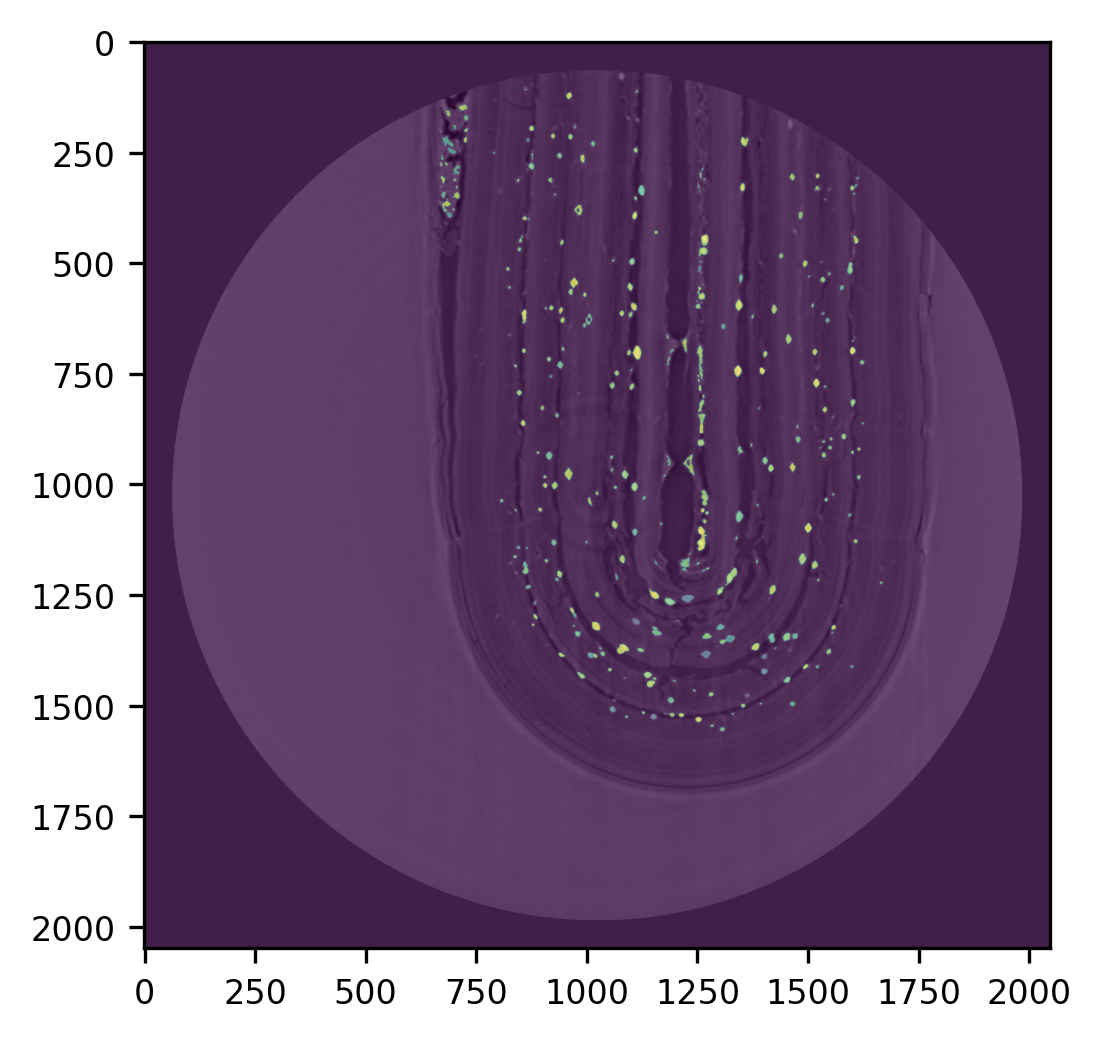

In [73]:
# Inspect slice
plt.imshow(data_3D[50,:,:], cmap='gray')
plt.imshow(regions_orientation_XYplane[50,:,:], cmap='viridis', alpha=0.5)

## Save vector filed data of particle orientation
We use `meshio` to save an `unstructured grid` `VTK` file containing the coordinates of each particle's center of mass and its orientation vector.
This file can be loaded and visualized in paraview:
<!-- ![pearls orientation](100slices_regions_orientation.png) -->
![pearls orientation](crystals_orientation_bg.png)

The coordinates [x,y,z] of the particle's center of mass are stored in the array: `centresOfMass[1:, [2, 1, 0]]`.
The particle's orientation vector [x,y,z] is in `MOIeigenVectors[1:, [8, 7, 6]]`.

In [68]:
meshio.write_points_cells(work_folder+"/crystals_orientation.vtk",
                          centresOfMass[1:, [2, 1, 0]], [],
                          point_data={"MOIeigenVector1": MOIeigenVectors[1:, [2, 1, 0]],
                                      "MOIeigenVector2": MOIeigenVectors[1:, [5, 4, 3]],
                                      "MOIeigenVector3": MOIeigenVectors[1:, [8, 7, 6]],
                                      "projection_phi": projection_theta_r[:, 0],
                                      "projection_theta": projection_theta_r[:, 1],
                                      "anisotropy": DA,
                                      "theta": theta,
                                      "sphericity": sphericity[1:].astype('float'),
                                      "volumes": pearl_volume[1:].astype('int')})

## Save results
We use `h5py` to export a HDF5 dataset of the analysis results

In [1]:
import h5py

In [67]:
MOIeigenValues.dtype

dtype('float32')

In [74]:
with h5py.File(res_folder+"/581681_punta_HR_stitch2_crystals_results_230221.hdf5", "w") as f:
    g_spam = f.create_group("spam")
    g_spam.create_dataset("volume", data=pearl_volume, dtype='uint32', compression="gzip")
    g_spam.create_dataset("sphericity", data=sphericity.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("MOIeigenValues", data=MOIeigenValues.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("MOIeigenVectors", data=MOIeigenVectors.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("DA", data=DA.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("centresOfMass", data=centresOfMass.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("projection_theta_r", data=projection_theta_r.astype('float16'), dtype='float16', compression="gzip")
    g_spam.create_dataset("theta", data=theta.astype('float16'), dtype='float16', compression="gzip")
    
    g_location = f.create_group("particle_location")
    g_location.create_dataset("dist_particle-pitfront", data=distances_pit_bottom.astype('float16'), dtype='float16', compression="gzip")
    g_location.create_dataset("dist_particle-void", data=distances_voids.astype('float16'), dtype='float16', compression="gzip")
    g_location.create_dataset("dist_void-pitfront", data=voids_dist_front.astype('float16'), dtype='float16', compression="gzip")

---
**To do:**
- [X] add DA scalar field
- [ ] display in Paraview scaling and coloring by DA
- [X] display in Paraview coloring by orientation angle with respect to X (0-90 deg)
- [ ] Generate table of the particle centroids and first eigenvector components.

---
# Dependencies

In [1]:
import watermark

In [ ]:
%load_ext watermark

%watermark
%watermark --iversions

---
# References
-  

---
# Acknowledgements
-  The authors acknowledge the [CERIC-ERIC](https://www.ceric-eric.eu/) Consortium for the access to experimental facilities and financial support